<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/5/Lab5_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment: Dogs and Cats Classification with AlexNet

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
from sklearn.model_selection import train_test_split
import zipfile
import glob
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
batch_size = 64

In [3]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')

1
Tesla K80


In [24]:
# dataloading adpated from https://www.kaggle.com/code/lys620/basic-pytorch-cnn-tutorial/notebook
base_dir = '/content/drive/MyDrive/class/deep_learning_data/'
train_dir = '/content/drive/MyDrive/class/deep_learning_data/lab5/data/train/train'
test_dir = '/content/drive/MyDrive/class/deep_learning_data/lab5/data/test/test'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f'Length of training data: {len(train_list)}')
print(f'Length of test data: {len(test_list)}')
train_list, val_list = train_test_split(train_list, test_size=0.2)
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #https://pytorch.org/hub/pytorch_vision_alexnet/
    ])

val_transforms = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms_not_normalized = transforms.Compose([   
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
test_data_not_normalized = dataset(test_list, transform=test_transforms_not_normalized)
val_data = dataset(val_list, transform=test_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)
test_loader_not_normalized = torch.utils.data.DataLoader(dataset = test_data_not_normalized, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

Length of training data: 25000
Length of test data: 12500


In [8]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()

        # input image 227x227x3

        self.net = nn.Sequential(
        # layer1
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0), # 55x55x96
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2), # 27x27x96

        # layer 2
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2), # 27x27x256
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2), # 13x13x256

        # layer 3
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1), # 13x13x384
        nn.ReLU(),

        # layer 4
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1), # 13x13x384
        nn.ReLU(),

        # layer 5
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1), # 13x13x256
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2), #, # 6x6x256

        # flattening
        nn.Flatten(),

        # layer 6
        nn.Linear(9216, 4096),
        nn.ReLU(),

        # layer 7
        nn.Linear(4096, 4096),
        nn.ReLU(),

        # layer 8
        nn.Linear(4096, num_classes))

    def forward(self, x):
        return self.net(x)

In [9]:
#Definition of hyperparameters
num_epochs = 10
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
model = AlexNet().to(cuda0)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# initialize arrays to hold loss and accuracy data
train_loss_list = np.zeros((num_epochs,))
accuracy_list = np.zeros((num_epochs,))

for epoch in tqdm.trange(num_epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    imgs = imgs.to(cuda0)
    labels = labels.to(cuda0)
    y_pred = model(imgs)
    loss = error(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)


  # Calculate accuracy
  imgs_test, labels_test = next(iter(val_loader))
  imgs_test = imgs_test.to(cuda0)
  labels_test = labels_test.to(cuda0)
  #labels_test = labels_test.type(torch.FloatTensor).to(cuda0)
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()
  print(f'Epoch: {epoch+1}, Training Loss: {train_loss_list[epoch]:0.5f}, Accuracy: {accuracy_list[epoch]:0.5f}')

 10%|█         | 1/10 [02:40<24:04, 160.49s/it]

Epoch: 1, Training Loss: 0.62379, Accuracy: 0.79688


 20%|██        | 2/10 [05:23<21:35, 161.93s/it]

Epoch: 2, Training Loss: 0.48675, Accuracy: 0.82812


 30%|███       | 3/10 [08:07<19:01, 163.01s/it]

Epoch: 3, Training Loss: 0.39034, Accuracy: 0.87500


 40%|████      | 4/10 [10:50<16:16, 162.77s/it]

Epoch: 4, Training Loss: 0.31904, Accuracy: 0.82812


 50%|█████     | 5/10 [13:39<13:45, 165.10s/it]

Epoch: 5, Training Loss: 0.25638, Accuracy: 0.87500


 60%|██████    | 6/10 [16:28<11:06, 166.64s/it]

Epoch: 6, Training Loss: 0.22238, Accuracy: 0.90625


 70%|███████   | 7/10 [19:18<08:22, 167.63s/it]

Epoch: 7, Training Loss: 0.19208, Accuracy: 0.87500


 80%|████████  | 8/10 [22:09<05:37, 168.54s/it]

Epoch: 8, Training Loss: 0.17419, Accuracy: 0.82812


 90%|█████████ | 9/10 [24:58<02:48, 168.69s/it]

Epoch: 9, Training Loss: 0.14925, Accuracy: 0.90625


100%|██████████| 10/10 [27:48<00:00, 166.80s/it]

Epoch: 10, Training Loss: 0.13563, Accuracy: 0.95312


Text(0.5, 0.98, 'Optimizer: Adam \n lr = 0.001 epochs = 10 \n Max Accuracy = 0.953')

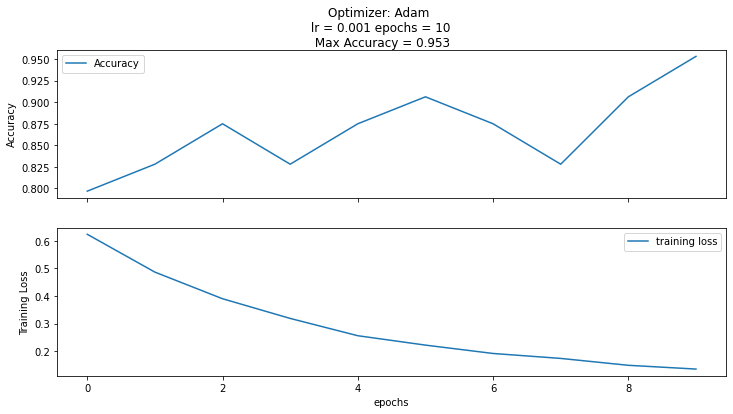

In [11]:
# plot test accuracy and training loss
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list,label='Accuracy')
ax1.set_ylabel("Accuracy")
ax1.legend()
ax2.plot(train_loss_list,label='training loss')
#ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Optimizer: Adam \n lr = 0.001 epochs = {num_epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [25]:
# get images and labels for test set
imgs_test, labels_test = next(iter(test_loader))
imgs_test = imgs_test.to(cuda0)
with torch.no_grad():
  y_pred = model(imgs_test)

In [26]:
# get guesses
guesses = torch.argmax(y_pred, dim=1) 

In [27]:
# get probabilities
smax=nn.Softmax(dim=1)
probability,_ = torch.max(smax(y_pred),dim=1) 

In [28]:
imgs_test_not_normalized, labels_test_not_normalized = next(iter(test_loader_not_normalized))

Text(0.5, 0.98, 'AlexNet Cat/Dog Classification Test')

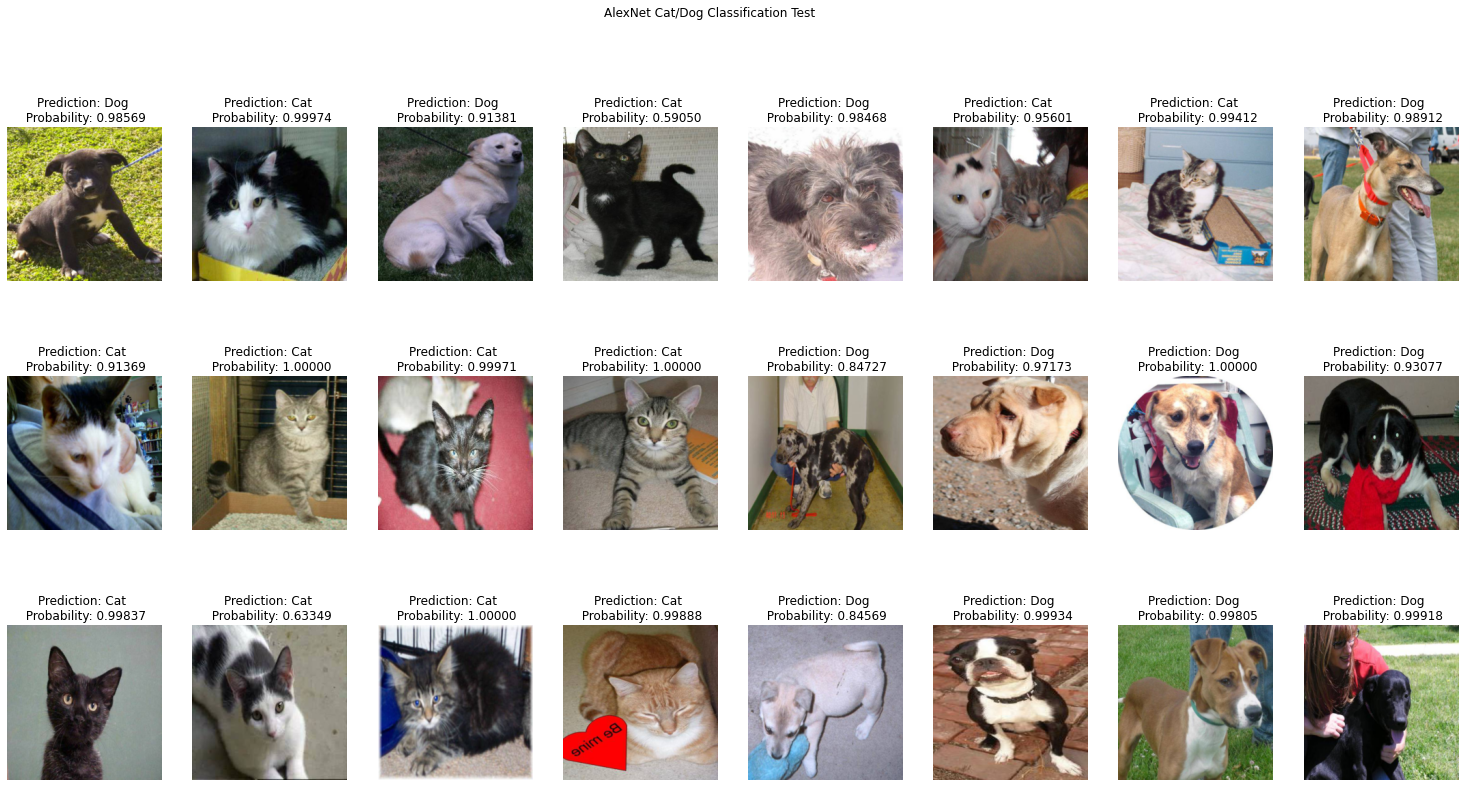

In [29]:
# plot classification accuracy
f,ax=plt.subplots(3,8,figsize=(26,13))
for i,(axs,predicted,true,prob) in enumerate(zip(ax.reshape(-1),guesses,labels_test,probability)):
  axs.imshow(imgs_test_not_normalized[i].permute(1,2,0))
  if predicted == 1:
            predicted='Dog'
  elif predicted == 0:
            predicted='Cat'
  axs.set_title(f'Prediction: {predicted} \n Probability: {prob:0.5f}')
  axs.axis('off')
f.suptitle('AlexNet Cat/Dog Classification Test')